# STAT778: Homework 5
*Sean Steinle*

## Table of Contents
1. [Inverse Transform Sampling and Metropolis-Hastings](#Inverse-Transform-Sampling-and-Metropolis-Hastings)
    - [Inverse Transform Sampling for G](#Inverse-Transform-Sampling-for-G)
    - [A Valid Envelope](#A-Valid-Envelope)
    - [Rejection Sampling for F](#Rejection-Sampling-for-F)
2. [Gibbs Sampling](#Gibbs-Sampling)

## Inverse Transform Sampling and Metropolis-Hastings

### Inverse Transform Sampling for G

Question 1a asks us to create a sampler for g.
1. We can treat g(x,y|z) as two independent variables g(x|z) and g(y|z).
2. Both g(x|z) and g(y|z) have the same functional form as each other. The only different is that x is distributed from (-inf,inf) while y is distributed from \[0,inf).
3. Both g(x|z) and g(y|z) have the same functional form as the Laplace distribution, where z is the location parameter and diversity is set sqrt(2). Note that g(x|z) amnd g(y|z) are scaled by a factor of 2*sqrt(2).
4. Because we know the Laplace distribution has a closed-form inverse, we can use inverse transform sampling to generate random numbers of the same functional form as g(x|z) and g(y|z).

In [1]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import uniform, normal, laplace
from numpy import sign,linspace
from math import exp, log

In [2]:
laplace()

2.1773023244739695

In [3]:
def slaplace(z: float = 0, beta: float = 2 ** 0.5): 
    """Generates samples from the Laplace distribution where z is the location parameter and beta is the diversity parameter."""
    u = uniform() #draw u, a float from [0,1]
    sample = z - beta * sign(u - 0.5) * log(1 - 2 * abs(u - 0.5)) #transform u using inverse cdf of the laplace distribution
    return sample * (2*(2**0.5)) #rescale sample

def g(x_loc: float, y_loc: float):
    """Uses our Laplace samplers to sample our two variables."""
    x_draw = slaplace(x_loc)
    y_draw = -1
    while y_draw < 0:
        y_draw = slaplace(y_loc)
    return x_draw,y_draw

def g_density(x: float, y: float, z: float = 0):
    """Calculates density of g for theta = (x,y). Assume z = 0."""
    return exp(-abs(x-z)/(2**0.5)) - exp(-abs(y-z)/(2**0.5))
    
def f_density(x: float, y: float, z: float = 0): #PROBLEM: this is density!
    """Calculates density of f for theta = (x,y). Assume z = 0."""
    if x>=y: return 0
    return exp(-abs((x-z)*(y-z)) - max(abs(x-z),abs(y-z)))

(array([6.0000e+00, 5.5000e+01, 3.7800e+02, 3.2940e+03, 2.6826e+04,
        5.9572e+04, 8.6850e+03, 1.0250e+03, 1.4700e+02, 1.2000e+01]),
 array([-44.12210386, -35.68577862, -27.24945337, -18.81312813,
        -10.37680288,  -1.94047763,   6.49584761,  14.93217286,
         23.3684981 ,  31.80482335,  40.2411486 ]),
 <BarContainer object of 10 artists>)

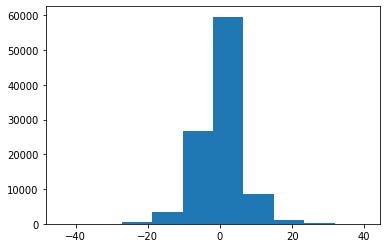

In [4]:
scaled_laplace_samples = [slaplace() for _ in range(100000)]
plt.hist(scaled_laplace_samples, bins = 10)

(array([1.0000e+00, 7.0000e+00, 7.2000e+01, 8.9300e+02, 1.0287e+04,
        6.8855e+04, 1.8044e+04, 1.6700e+03, 1.5800e+02, 1.3000e+01]),
 array([-38.44935615, -31.60465721, -24.75995826, -17.91525932,
        -11.07056038,  -4.22586143,   2.61883751,   9.46353645,
         16.3082354 ,  23.15293434,  29.99763328]),
 <BarContainer object of 10 artists>)

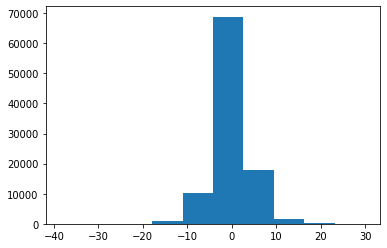

In [5]:
laplace_samples = [laplace(0, 2*(2**0.5)) for _ in range(100000)]
plt.hist(laplace_samples, bins = 10)

As a quick sanity check, we can see that our Laplace sampling function generates the same shape as Numpy's Laplace sampler.

### A Valid Envelope

Text(0.5, 1.0, 'Domains of F and G')

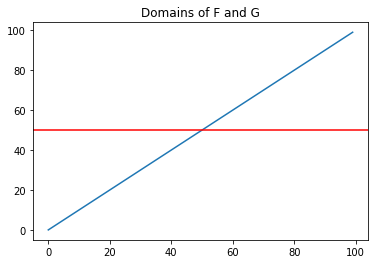

In [6]:
plt.plot(range(100))
plt.axhline(y = 50, color = 'red')
plt.title("Domains of F and G")

prove g majorizes f
prove g's domain is the same as f's domain


To prove that g (or some scaling of g) is a valid envelope for f, we must prove two things: that g's domain spans the domain of f, and that g majorizes.
- g's domain spans the domain of f because g's domain is a rotation of f's domain (as shown in the plot above). g's domain encompasses all real numbers above Y=0, whereas f's domain encompasses all real numbers where X>Y. The bivariate density of f when x = (x-y)/sqrt(2), y = (x+y)/sqrt(2) rotates f's domain such that g spans f's domain.
- exp(abs(z))\*g majorizes f because...
    - if x is further from z than y is...
    - else...
    TD there is some algebra to do here, ask Morgan

POST OFFICE HOURS TO DO LIST:
- 1a
    - treat z as a constant
    - factorize X and Y
        - they are essentially the same thing too, but y's domain is different
    - can figure out how to sample by googling how to sample laplace/double exponential
        - exponential + coin flip (+ rejection < 0 for y)
        - should check against np.random.laplace
- 1b
    - valid envelope if g's domain >= f and if g majorizes f.
    - g's domain >= f because both are from -inf>inf and 0>inf for X and Y respectively. just a trivial shift of (xtilda-ytilda) for f
    - e^|z|\*g majorizes f because ...
        - decompose max into two cases, makes things easier
- 1c
    - rejection sampling baby!
    
{\displaystyle F^{-1}(p)=\mu -b\,\operatorname {sgn}(p-0.5)\,\ln(1-2|p-0.5|).}

### Rejection Sampling for F

In [70]:
z = 0
M = exp(z)

def mh_step(theta: tuple):
    x,y = theta
    proposal = g(x,y) #sample s from g(s)
    accept_prob = f_density(x,y)/(M+g_density(x,y)) #accept with probability f(s)/g(s)+M
    print(f"got accept prob {accept_prob} for pair ({x},{y})")
    return {'accepted': accept_prob > uniform(), 'value': proposal, 'accept_prob': accept_prob}

def mh(n_samples: int, n_burn: int, start_params: tuple=(1,2)):
    results = []
    lag_count = 0
    curr_params = start_params
    for _ in range(n_burn): #burn-in period, results aren't saved
        result = mh_step(curr_params)
        if result['accepted']:
            curr_params = result['value']
    for i in range(n_samples):
        result = mh_step(curr_params)
        if result['accepted']:
            curr_params = result['value']
        results.append(result)
    return results

In [71]:
mh_step((0.01,0.1))

got accept prob 0.8517846874934188 for pair (0.01,0.1)


{'accepted': True,
 'value': (1.2068054377659634, 7.522197576230782),
 'accept_prob': 0.8517846874934188}

In [ ]:
results = mh(100000, 10000, (0.01,0.1))
results

got accept prob 0.8517846874934188 for pair (0.01,0.1)
got accept prob 0.4313105182024799 for pair (-0.5550924427348635,0.5336317761597024)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.3318763

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for pair (0.8035090613337353,9.331876329697282)
got accept prob 3.1347299038097486e-08 for 

In [ ]:
df = pd.DataFrame(results)
df

In [69]:
df['accepted'].sum()

0

In [ ]:
x,y = (12,17)
f_density(x,y)/(g_density(x,y)+exp(0))

In [ ]:
step(1,2)

In [ ]:
#TODO
#implement f(s) (rlly f(x,y))
#do f(s)/(g(s)+M)

## Gibbs Sampling